In [1]:
%matplotlib inline
from __future__ import division
import numpy as np

import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import networkx as nx
from djPyi2 import mpltools
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import matplotlib.patches as patches
from djPyi2 import Common as CM
import matplotlib.image as mpimg

import numpy as np
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as mpatch

import matplotlib.transforms as mtransforms

In [191]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

In [2]:
dy_name = 'Figures'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

# Data Prep

In [4]:
def modify_per_sample(df, sample_info):
    
    df = df.copy()
    try:
        df['sample'] = df.index
    except:
        pass

    cols = ['CELL_TYPE', 'STUDY','SEX', 'GENETICALLY_SIMILAR_POPULATION_GROUP']
    def mod_ethnicity(x):
        if x == 'AFR':
            return 'African'
        else:
            return 'Non African'
        
    df = df.join(sample_info[cols])
    df['ethnicity_mod'] = df['GENETICALLY_SIMILAR_POPULATION_GROUP'].apply(lambda x: mod_ethnicity(x))
    
    df = df.sort_values(['STUDY', 'CELL_TYPE', 'ethnicity_mod', 'SEX','sample'])
    df['x'] = range(df.shape[0])
    return df

def add_plot_colors(df):
    df = df.copy()
    cell_type_color_dict = {'Blood': '#efe4bf', 'Fibroblast': '#dce8b2', 'iPSC':'#c2d6c8'}
    ethnicity_color_dict = {'African': '#baced8', 'Non African': '#6b818c'}
    
    df['color_fill'] = df.ethnicity_mod.apply(lambda x: ethnicity_color_dict[x])
    df['color_edge'] = df.CELL_TYPE.apply(lambda x: cell_type_color_dict[x])
    return df 

In [5]:
sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')

In [15]:
ipscore_sample_info =  pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ipscore_sample_info/ipscore_info.pkl')

In [45]:
ipscore_sample_info['SELF_REPORT_AFRICAN'] = ipscore_sample_info.REPORTED_RACE_ETHNICITY.isin(['African American', 'Black', 'Black / Korean', 'Black / Mixed / Hispanic'])

In [6]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_filt_geno/hipstr_per_sample_noxy_length.tsv'
hipstr_length_per_sample_ipscore = pd.read_table(fn, index_col=0).pipe(modify_per_sample, sample_info).pipe(add_plot_colors)

fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_geno/hipstr_per_sample_noxy_length.tsv'
hipstr_length_per_sample_hipsci_ref = pd.read_table(fn, index_col=0).pipe(modify_per_sample, sample_info).pipe(add_plot_colors)

fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/hipsci_filt_geno/hipstr_per_sample_noxy_length.tsv'
hipstr_length_per_sample_hipsci = pd.read_table(fn, index_col=0).pipe(modify_per_sample, sample_info).pipe(add_plot_colors)

In [21]:
hipstr_length_per_sample_ipscore = hipstr_length_per_sample_ipscore.join(ipscore_sample_info[['REPORTED_RACE_ETHNICITY']])

In [48]:
hipstr_length_per_sample_ipscore = hipstr_length_per_sample_ipscore.join(ipscore_sample_info[['SELF_REPORT_AFRICAN']])

In [71]:
samples_non_hli = sample_info[sample_info.STUDY != 'HLI'].WGS_ID.tolist()

# Plot Functions

In [64]:
def plot_per_sample_barplot(df, order_of_cols, colors, ax, axsubx):

    df[order_of_cols].plot(kind='bar', stacked =True, ax = ax, colors = colors)
    ax.set_xticklabels('')
    ax.tick_params(axis = 'x', top = False, bottom = False)
    ax.tick_params(axis = 'y', width = 1, length = 3)
    ax.xaxis.grid(False)

    leg = ax.legend(bbox_to_anchor = (1,1), loc = 'upper left', frameon=True)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('black')

    group_order = ['STUDY', 'CELL_TYPE', 'ethnicity_mod']
    study_color_dict = {'HipSci': '#96b9f2', 'iPSCORE': '#95f1b0', 'HLI':'black'}
    ethnicity_color_dict = {'African': '#baced8', 'Non African': '#6b818c'}
    cell_type_color_dict = {'Blood': '#efe4bf', 'Fibroblast': '#dce8b2', 'iPSC':'#c2d6c8'}
    color_dict_order = [study_color_dict, cell_type_color_dict, ethnicity_color_dict]
    bottoms = [-200, -400, -600]
    heights = [200, 200, 200]
    label_bools = [True, False, False]


#     d_ranges_study = dict_gb_ranges(df, 'STUDY')

#     divider = make_axes_locatable(ax)

#     axsubx = divider.append_axes("bottom", size=0.4, pad=0)
    x_min, x_max = ax.get_xlim()
    axsubx.set_xlim(x_min, x_max)
    axsubx.set_ylim(-700,0)
    mpltools.annotate_multi_level(axsubx, df, group_order, color_dict_order, bottoms, heights, label_bools)
    axsubx.set_axis_off()
    return ax, axsubx, leg

In [222]:
def plot_missing_vs_nref(ax, df, s= 40, fs = 10, lw = 1, ms_legend = 10, mw_legend = 3):
    cell_type_color_dict = {'Blood': '#efe4bf', 'Fibroblast': '#dce8b2', 'iPSC':'#c2d6c8'}
    ethnicity_color_dict = {'African': '#baced8', 'Non African': '#6b818c'}
    
    ax.scatter(df.MISSING, df.NREF, edgecolors=df.color_edge, c= df.color_fill, s=s, lw = lw)
    labels = ethnicity_color_dict.keys()
    colors = ethnicity_color_dict.values()
    patches = mpltools.get_legend_patches(labels, markerfacecolor=colors, markersize = ms_legend)
    
    labels2 = cell_type_color_dict.keys()
    colors2 = cell_type_color_dict.values()
    patches_2 = mpltools.get_legend_patches(labels2, markerfacecolor='white', markeredgecolor=colors2, markersize=ms_legend, markeredgewidth=mw_legend)
    
    patches_all = patches + patches_2

    leg = ax.legend(handles = patches_all)
    ax.set_xlabel('No. Missing', size = fs, weight = 'bold')
    ax.set_ylabel('No. Non Reference', size = fs, weight = 'bold')
    
    return ax, leg, patches_all

In [202]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.2
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['ytick.major.pad'] = 1
mpl.gridspec.rcParams['xtick.major.pad'] = 1
mpl.gridspec.rcParams['axes.titlesize'] = 10
mpl.gridspec.rcParams['axes.labelsize'] = 8
mpl.gridspec.rcParams['ytick.labelsize'] = 6
mpl.gridspec.rcParams['xtick.labelsize'] = 6
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'
mpl.gridspec.rcParams['grid.linewidth'] = 0.5

mpl.gridspec.rcParams['font.size'] = 7

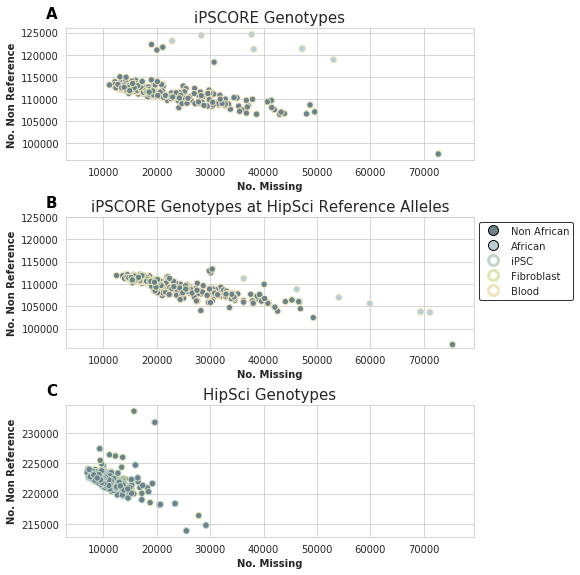

In [55]:
with sns.axes_style('whitegrid'):

    fig, ax = plt.subplots(3,1, figsize= (8,8), sharex= True)

    ax1 = ax[0]
    ax2 = ax[1]
    ax3= ax[2]
    
    
    
    ax1, leg1, patches_all = plot_missing_vs_nref(ax1, hipstr_length_per_sample_ipscore)
    ax2, leg2, patches_all = plot_missing_vs_nref(ax2, hipstr_length_per_sample_hipsci_ref)
    ax3, leg3, patches_all = plot_missing_vs_nref(ax3, hipstr_length_per_sample_hipsci)
    
    leg1.set_visible(False)
    leg3.set_visible(False)
    
    leg = ax2.legend(handles = patches_all, bbox_to_anchor = (1,1), loc = 'upper left', frameon = True)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('black')

    ax1.xaxis.set_tick_params(which='both', labelbottom=True, )
    ax2.xaxis.set_tick_params(which='both', labelbottom=True)

    
    
    yticks = np.arange(100000, 128000, 5000)
    
    ax1.set_yticks(yticks)
    ax2.set_yticks(yticks)
    ax1.set_yticklabels(yticks)
    ax2.set_yticklabels(yticks)
    
    ax1.set_title('iPSCORE Genotypes', fontsize = 15)
    ax2.set_title('iPSCORE Genotypes at HipSci Reference Alleles', fontsize = 15)
    ax3.set_title('HipSci Genotypes', fontsize = 15)
        
    plt.tight_layout()
    
    labels = ['A', 'B', 'C']
    for i, a in enumerate([ax1, ax2, ax3]):
        mpltools.label_offset_axes(a, fig, labels[i], x = -20, y = 10)
    
    
    fig.savefig(os.path.join(private_out, 'SupFig_Missing_vs_NREF_HipSTR.png'), dpi=500, bbox_inches='tight') 
    

# Calls Per Sample

In [77]:
hl_ipscore = hipstr_length_per_sample_ipscore[hipstr_length_per_sample_ipscore['sample'].isin(samples_non_hli)]
hl_ipscore_hr = hipstr_length_per_sample_hipsci_ref[hipstr_length_per_sample_ipscore['sample'].isin(samples_non_hli)]

In [88]:
study_color_dict = {'HipSci': '#96b9f2', 'iPSCORE': '#95f1b0', 'HLI':'black'}
ethnicity_color_dict = {'African': '#baced8', 'Non African': '#6b818c'}
cell_type_color_dict = {'Blood': '#efe4bf', 'Fibroblast': '#dce8b2', 'iPSC':'#c2d6c8'}
colors_underbar_dict = study_color_dict
colors_underbar_dict.update(ethnicity_color_dict)
colors_underbar_dict.update(cell_type_color_dict)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


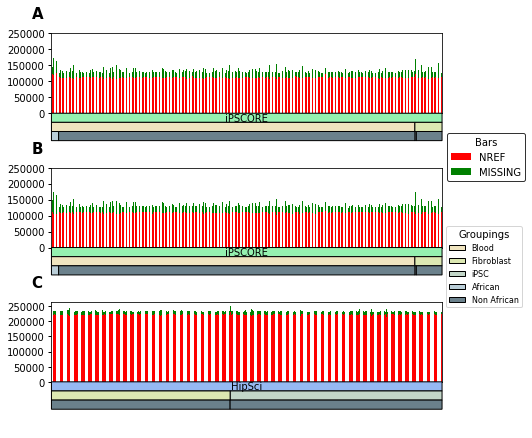

In [100]:
fig = plt.figure(figsize = (7,7))
gs = mpl.gridspec.GridSpec(3, 1, 
                       figure =fig,
                       width_ratios=[1], height_ratios = [1, 1, 1], wspace = 0.5, hspace=0.2)

# fig, ax = plt.subplots(3,1, figsize= (7,7), sharey = True)
subgrid1 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs[0],height_ratios=(1,0.4), 
                                            wspace=0, hspace= 0.0)
ax1_a = fig.add_subplot(subgrid1[0])
ax1_b = fig.add_subplot(subgrid1[1])
ax1_a, ax1_b, leg1 = plot_per_sample_barplot(hl_ipscore, 
                              ['NREF', 'MISSING'], ['r', 'g'], ax1_a, ax1_b)

subgrid2 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs[1],height_ratios=(1,0.4), 
                                            wspace=0, hspace= 0.0)
ax2_a = fig.add_subplot(subgrid2[0])
ax2_b = fig.add_subplot(subgrid2[1])

ax2_a, ax2_b, leg2 = plot_per_sample_barplot(hl_ipscore_hr, 
                              ['NREF', 'MISSING'], ['r', 'g'], ax2_a, ax2_b)



subgrid3 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs[2],height_ratios=(1,0.4), 
                                            wspace=0, hspace= 0.0)
ax3_a = fig.add_subplot(subgrid3[0])
ax3_b = fig.add_subplot(subgrid3[1])

ax3_a, ax3_b, leg3 = plot_per_sample_barplot(hipstr_length_per_sample_hipsci, 
                              ['NREF', 'MISSING'], ['r', 'g'], ax3_a, ax3_b)


leg1.set_visible(False)
leg3.set_visible(False)
leg2.set_bbox_to_anchor((1, 1.5))
leg2.set_title('Bars')
yticks = np.arange(0,251000, 50000)

for a in [ax1_a, ax2_a, ax3_a]:
    a.set_yticks(yticks)

# ax1_a.set_title('iPSCORE Genotypes', fontsize = 15)

labels_underbar = ['Blood', 'Fibroblast', 'iPSC', 'African', 'Non African']
colors_underbar = [colors_underbar_dict[i] for i in labels_underbar]
patches = mpltools.get_legend_patches(labels_underbar, just_rect=True, rectfacecolor=colors_underbar)
leg = ax3_a.legend(handles = patches, bbox_to_anchor = [1,2], loc = 'upper left', ncol = 1, fontsize = 8,
                  title = 'Groupings')



labels = ['A', 'B', 'C']
for i, a in enumerate([ax1_a, ax2_a, ax3_a]):
    mpltools.label_offset_axes(a, fig, labels[i], x = -20, y = 15)

fig.savefig(os.path.join(private_out, 'SupFig_Calls_Per_Sample_HipSTR.png'), dpi=500, bbox_inches='tight') 
    

# Additional info

In [106]:
hl_ipscore['NREF_iPSCORE_GT'] = hl_ipscore.NREF
hl_ipscore_hr['NREF_iPSCORE_HR'] = hl_ipscore_hr.NREF

comp = hl_ipscore.join(hl_ipscore_hr[['NREF_iPSCORE_HR']])
ethnicity_color_dict = {'African': '#baced8', 'Non African': '#6b818c'}

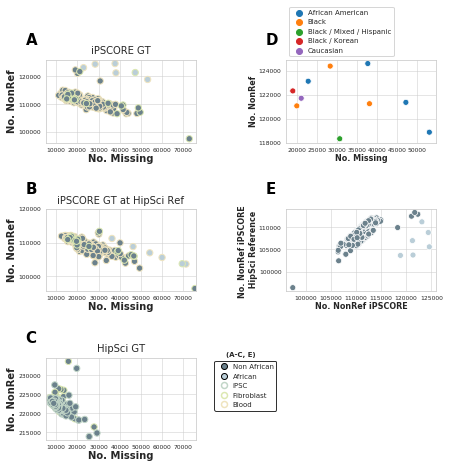

In [224]:
with sns.axes_style('whitegrid'):

    fig, ax = plt.subplots(3,2, figsize= (7,7), sharex= False, gridspec_kw={'wspace':0.6, 'hspace': 0.8})

    ax1 = ax[0][0]
    ax2 = ax[1][0]
    ax3= ax[2][0]
    ax4 = ax[0][1]
    ax5 = ax[1][1]
    ax6 = ax[2][1]
    ax6.set_axis_off()
    
    
    ax1, leg1, patches_all = plot_missing_vs_nref(ax1, hl_ipscore)
    ax2, leg2, patches_all = plot_missing_vs_nref(ax2, hl_ipscore_hr)
    ax3, leg3, patches_all = plot_missing_vs_nref(ax3, hipstr_length_per_sample_hipsci, 
                                                  ms_legend=6, mw_legend = 1.5)
    
    leg1.set_visible(False)
    leg3.set_visible(False)
    leg2.set_visible(False)
    
    leg = ax3.legend(handles = patches_all, bbox_to_anchor = (1.1,1), loc = 'upper left', frameon = True,
                     ncol = 1)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('black')

    ax1.xaxis.set_tick_params(which='both', labelbottom=True, )
    ax2.xaxis.set_tick_params(which='both', labelbottom=True)

    ax1.set_xlim(5000, max(ax1.get_xlim()))
    ax2.set_xlim(ax1.get_xlim())
    ax3.set_xlim(ax1.get_xlim())
    yticks = np.arange(100000, 128000, 10000)
    
    ax1.set_yticks(yticks)
    ax2.set_yticks(yticks)
    ax1.set_yticklabels(yticks)
    ax2.set_yticklabels(yticks)
    
    ax1.set_title('iPSCORE GT', fontsize = 10)
    ax2.set_title('iPSCORE GT at HipSci Ref', fontsize = 10, pad = 5)
    ax3.set_title('HipSci GT', fontsize = 10)
        
    
    ax4 = sns.scatterplot(data = hl_ipscore[hl_ipscore.NREF > 117000], ax = ax4, x = 'MISSING', y = 'NREF', 
                    hue = 'REPORTED_RACE_ETHNICITY')
    
    ax4.legend().set_visible(False)
    handles, labels = ax4.get_legend_handles_labels()
    ax4.legend(handles = handles[1:], bbox_to_anchor = (0,1), loc = 'lower left')
    
    for a in [ax1, ax2, ax3, ax4]:
        
        a.set_xlabel('No. Missing')
        a.set_ylabel('No. NonRef')
    
    ax5 =  sns.scatterplot(data = comp, x = 'NREF_iPSCORE_GT',
                           y = 'NREF_iPSCORE_HR', 
                    hue = 'ethnicity_mod', ax = ax5, palette = ethnicity_color_dict)
    
    ax5.set(xlabel = 'No. NonRef iPSCORE', ylabel='No. NonRef iPSCORE \n HipSci Reference')
    ax5.legend(handles = patches_all[:2], bbox_to_anchor = (0,1), loc = 'lower left')
    ax5.legend().set_visible(False)
    
#     plt.tight_layout(h_pad=0.05, w_pad=0.05, pad = 0)
    labels = ['A', 'B', 'C', 'D', 'E']
    for i, a in enumerate([ax1, ax2, ax3,ax4, ax5]):
        mpltools.label_offset_axes(a, fig, labels[i], x = -20, y = 15)

    ax3.text(1.2, 1, '(A-C, E)', fontweight = 'bold', transform = ax3.transAxes, clip_on = False,
          horizontalalignment='left',  verticalalignment='bottom')
    
    fig.savefig(os.path.join(private_out, 'SupFig_Missing_vs_NREF_HipSTR.png'), dpi=500, bbox_inches='tight') 


# Twin Concordance/iPSC Concordance

In [181]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_filt_sr_geno/hipstr_per_pair_length.tsv'
rr_length_per_pair_ipscore = pd.read_table(fn, index_col=0)

fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_sr_geno/hipstr_per_pair_length.tsv'
rr_length_per_pair_ipscore_hipsci_ref = pd.read_table(fn, index_col=0)

fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/hipsci_filt_geno/hipstr_per_pair_length.tsv'
rr_length_per_pair_hipsci = pd.read_table(fn, index_col=0)

In [197]:
def get_highest_rr_unique_pairs(rr_per_pair_summary_fib_ipsc):
    rr_per_pair_summary_fib_ipsc['PAIR'] = rr_per_pair_summary_fib_ipsc.index
    rr_per_pair_summary_fib_ipsc['P1'] = rr_per_pair_summary_fib_ipsc['PAIR'].apply(lambda x: x.split('_')[0])

    t = rr_per_pair_summary_fib_ipsc.groupby(['P1']).RR.describe()
    t['P1'] = t.index
    inds = t[t['count'] > 1].index.tolist()

    dfs = []
    for x, df in rr_per_pair_summary_fib_ipsc[rr_per_pair_summary_fib_ipsc.P1.isin(inds)].groupby('P1'):
        df = df[df.RR == df.RR.max()].head(1)
        dfs.append(df)

    tdf = pd.concat(dfs)

    best_pairs = pd.concat([rr_per_pair_summary_fib_ipsc[~rr_per_pair_summary_fib_ipsc.P1.isin(inds)], tdf])
    return  rr_per_pair_summary_fib_ipsc, best_pairs

In [199]:
rr_unique_hipsci, bp = get_highest_rr_unique_pairs(rr_length_per_pair_hipsci)
rr_length_per_pair_hipsci['pair_id'] = rr_length_per_pair_hipsci.index

In [182]:
def plot_hist(ax, df):
    ax.hist(df.RR,  bins = 20)
    ax.set(xlabel = 'Replication Percentage', ylabel = 'No. Pairs')
    return ax

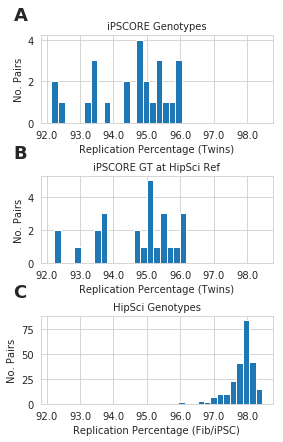

In [201]:
with sns.axes_style('whitegrid'):

    fig, ax = plt.subplots(3,1, figsize= (4,6), sharex= True)

    ax1 = ax[0]
    ax2 = ax[1]
    ax3= ax[2]
    
    
    
    ax1 = plot_hist(ax1, rr_length_per_pair_ipscore)
    ax2 = plot_hist(ax2, rr_length_per_pair_ipscore_hipsci_ref)
    ax3 = plot_hist(ax3, rr_unique_hipsci)
    ax1.xaxis.set_tick_params(which='both', labelbottom=True)
    ax2.xaxis.set_tick_params(which='both', labelbottom=True)

    for a in [ax1, ax2]:
        a.set(xlabel = 'Replication Percentage (Twins)', ylabel = 'No. Pairs')
        
    ax3.set(xlabel = 'Replication Percentage (Fib/iPSC)', ylabel = 'No. Pairs')
    
    ax1.set_title('iPSCORE Genotypes', fontsize = 10)
    ax2.set_title('iPSCORE GT at HipSci Ref', fontsize = 10)
    ax3.set_title('HipSci Genotypes', fontsize = 10)
    t = fig.text(0.05, 0.98, 'A', weight='bold', 
             size=18)
    
    t = fig.text(0.05, 0.66, 'B', weight='bold', 
             size=18)
    
    
    t = fig.text(0.05, 0.34, 'C', weight='bold', 
             size=18)
    
    for a in [ax1, ax2, ax3]:
        a.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=1))
    
    
    plt.tight_layout()
    
    
    fig.savefig(os.path.join(private_out, 'SupFig_Replication_Per_Pair_HipSTR.png'), dpi=500, bbox_inches='tight') 